In [13]:
%load_ext load_style
%load_style talk.css
from IPython.display import YouTubeVideo, Image

# Wavelets in Python

[Nicolas Fauchereau](mailto:Nicolas.Fauchereau@gmail.com)

This notebook contains quick comparisons of 2 convenient packages implementing wavelet analysis in Python: 
    
+ [waipy](https://github.com/mabelcalim/waipy) 
+ [pycwt](https://github.com/regeirk/pycwt)

as well as an implementation by **Dr. Toru Miyama** rectifying the bias in favor of large scale existing in the previous packages

The examples follow the ones exposed in 

[A practical guide to wavelet analysis](http://journals.ametsoc.org/doi/pdf/10.1175/1520-0477%281998%29079%3C0061%3AAPGTWA%3E2.0.CO%3B2)

from Christopher Torrence and Gil P. Compo

using the NINO3.4 seasonal time series

See also the [Interactive Wavelet page](http://ion.exelisvis.com/)

### references

+ Torrence, C., and G. P. Compo, 1998: [A practical guide to wavelet analysis](http://journals.ametsoc.org/doi/pdf/10.1175/1520-0477%281998%29079%3C0061%3AAPGTWA%3E2.0.CO%3B2). Bull. Amer. Meteor. Soc., 79, 6178.  


+ Liu, Y., X.S. Liang, and R.H. Weisberg, 2007: Rectification of the bias in the wavelet power spectrum. Journal of Atmospheric and Oceanic Technology, 24(12), 2093-2102. [http://ocgweb.marine.usf.edu/~liu/wavelet.html](http://ocgweb.marine.usf.edu/~liu/wavelet.html)

In [1]:
%matplotlib inline
import numpy as np 
from matplotlib import pyplot as plt

### loads the data 

In [2]:
data = np.loadtxt('../data/sst_nino3.dat')

In [3]:
N = data.size

In [4]:
t0=1871
dt=0.25
units='^{\circ}C'
label='NINO3 SST'

In [5]:
time = np.arange(0, N) * dt + t0

## 1. [Waipy](Waipy)

In [6]:
import waipy

In [7]:
data_norm = waipy.normalize(data)

In [8]:
alpha = np.corrcoef(data_norm[0:-1], data_norm[1:])[0,1]; 
print("Lag-1 autocorrelation = {:4.2f}".format(alpha))

Lag-1 autocorrelation = 0.77


In [9]:
result = waipy.cwt(data_norm, 1, 1, 0.25, 2, 4/0.25, alpha, 6, mother='Morlet',name='x')

In [10]:
waipy.wavelet_plot?

/Users/nicolasf/anaconda/lib/python2.7/site-packages/numpy/core/numeric.py:462: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


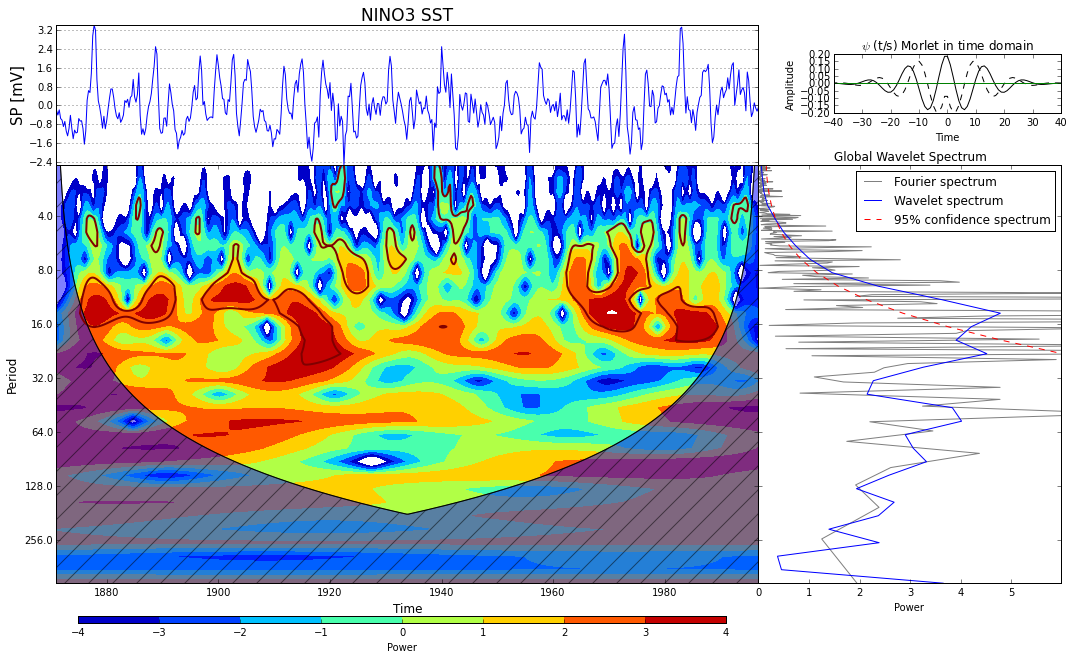

In [11]:
waipy.wavelet_plot(label, time, data_norm, 0.03125, result); 

## 2. pycwt

In [15]:
import sys, os
sys.path.append(os.path.join(os.environ.get('HOME'), 'sources/python'))

In [16]:
import pycwt

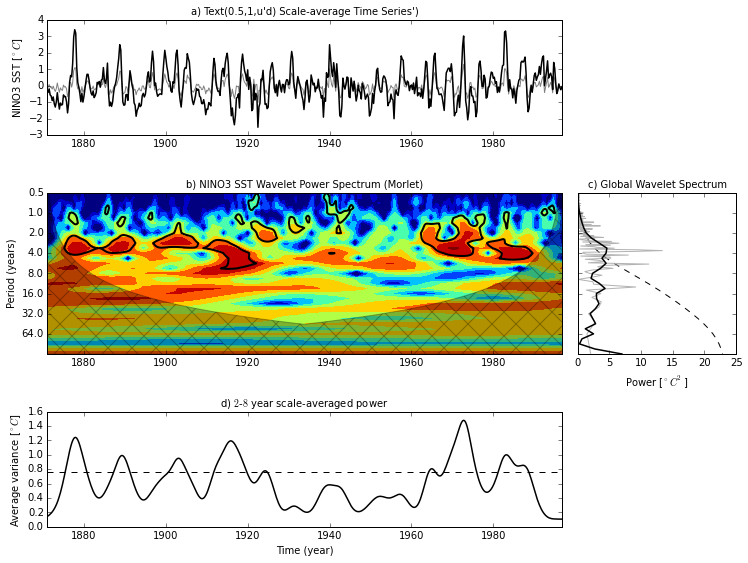

In [37]:
"""
Python sample script for wavelet analysis and the statistical approach
suggested by Torrence and Compo (1998) using the wavelet module. To run
this script successfully, the matplotlib module has to be installed

DISCLAIMER
    This module is based on routines provided by C. Torrence and G.
    Compo available at http://paos.colorado.edu/research/wavelets/
    and on routines provided by A. Brazhe available at
    http://cell.biophys.msu.ru/static/swan/.

    This software may be used, copied, or redistributed as long as it
    is not sold and this copyright notice is reproduced on each copy
    made. This routine is provided as is without any express or implied
    warranties whatsoever.

AUTHOR
    Sebastian Krieger
    email: sebastian@nublia.com

REVISION
    2 (2011-01-11 15:21)
    1 (2010-12-25 20:09)

REFERENCES
    [1] Torrence, Christopher and Compo, Gilbert P. (1998). A Practical
        Guide to Wavelet Analysis

"""

__version__ = '$Revision: 2 $'
# $Source$

import numpy
import pylab
from pycwt import wav as wavelet

avg1, avg2 = (2, 8)                  # Range of periods to average
slevel = 0.95                        # Significance level

std = data.std()                      # Standard deviation
std2 = std ** 2                      # Variance
var = (data - data.mean()) / std       # Calculating anomaly and normalizing

N = data.size                         # Number of measurements
time = numpy.arange(0, N) * dt + t0  # Time array in years

dj = 0.25                            # Four sub-octaves per octaves
s0 = -1 #2 * dt                      # Starting scale, here 6 months
J = -1  #7 / dj                      # Seven powers of two with dj sub-octaves
#alpha = 0.0                          # Lag-1 autocorrelation for white noise
alpha, _, _ = wavelet.ar1(data)

mother = wavelet.Morlet(6.)          # Morlet mother wavelet with wavenumber=6
#mother = wavelet.Mexican_hat()       # Mexican hat wavelet, or DOG with m=2
#mother = wavelet.Paul(4)             # Paul wavelet with order m=4
#mother = wavelet.DOG(6)              # Derivative of the Gaussian, with m=6

# The following routines perform the wavelet transform and siginificance
# analysis for the chosen data set.
wave, scales, freqs, coi, fft, fftfreqs = wavelet.cwt(data, dt, dj, s0, J,
                                                      mother)
iwave = wavelet.icwt(wave, scales, dt, dj, mother)
power = (abs(wave)) ** 2             # Normalized wavelet power spectrum
fft_power = std2 * abs(fft) ** 2     # FFT power spectrum
period = 1. / freqs

signif, fft_theor = wavelet.significance(1.0, dt, scales, 0, alpha,
                        significance_level=slevel, wavelet=mother)
sig95 = numpy.ones([1, N]) * signif[:, None]
sig95 = power / sig95                # Where ratio > 1, power is significant

# Calculates the global wavelet spectrum and determines its significance level.
glbl_power = std2 * power.mean(axis=1)
dof = N - scales                     # Correction for padding at edges
glbl_signif, tmp = wavelet.significance(std2, dt, scales, 1, alpha,
                       significance_level=slevel, dof=dof, wavelet=mother)

# Scale average between avg1 and avg2 periods and significance level
sel = pylab.find((period >= avg1) & (period < avg2))
Cdelta = mother.cdelta
scale_avg = (scales * numpy.ones((N, 1))).transpose()
# As in Torrence and Compo (1998) equation 24
scale_avg = power / scale_avg
scale_avg = std2 * dj * dt / Cdelta * scale_avg[sel, :].sum(axis=0)
scale_avg_signif, tmp = wavelet.significance(std2, dt, scales, 2, alpha,
                            significance_level=slevel, dof=[scales[sel[0]],
                            scales[sel[-1]]], wavelet=mother)

# The following routines plot the results in four different subplots containing
# the original series anomaly, the wavelet power spectrum, the global wavelet
# and Fourier spectra and finally the range averaged wavelet spectrum. In all
# sub-plots the significance levels are either included as dotted lines or as
# filled contour lines.
pylab.close('all')
pylab.ion()
fontsize = 'medium'
params = {'text.fontsize': fontsize,
          'xtick.labelsize': fontsize,
          'ytick.labelsize': fontsize,
          'axes.titlesize': fontsize,
          'text.usetex': False # important, on my config fails if true
         }
pylab.rcParams.update(params)          # Plot parameters
figprops = dict(figsize=(11, 8), dpi=72)
fig = pylab.figure(**figprops)

# First sub-plot, the original time series anomaly.
ax = pylab.axes([0.1, 0.75, 0.65, 0.2])
ax.plot(time, iwave, '-', linewidth=1, color=[0.5, 0.5, 0.5])
ax.plot(time, data, 'k', linewidth=1.5)
ax.set_title('a) %s' % (title, ))
if units != '':
  ax.set_ylabel(r'%s [$%s$]' % (label, units,))
else:
  ax.set_ylabel(r'%s' % (label, ))

# Second sub-plot, the normalized wavelet power spectrum and significance level
# contour lines and cone of influece hatched area.
bx = pylab.axes([0.1, 0.37, 0.65, 0.28], sharex=ax)
levels = [0.0625, 0.125, 0.25, 0.5, 1, 2, 4, 8, 16]
bx.contourf(time, numpy.log2(period), numpy.log2(power), numpy.log2(levels),
            extend='both')
bx.contour(time, numpy.log2(period), sig95, [-99, 1], colors='k',
           linewidths=2.)
bx.fill(numpy.concatenate([time, time[-1:]+dt, time[-1:]+dt,time[:1]-dt, time[:1]-dt]),
        numpy.log2(numpy.concatenate([coi,[1e-9], period[-1:], period[-1:], [1e-9]])),
        'k', alpha=0.3,hatch='x')

bx.set_title('b) %s Wavelet Power Spectrum (%s)' % (label, mother.name))
bx.set_ylabel('Period (years)')
Yticks = 2 ** numpy.arange(numpy.ceil(numpy.log2(period.min())),
                           numpy.ceil(numpy.log2(period.max())))
bx.set_yticks(numpy.log2(Yticks))
bx.set_yticklabels(Yticks)
bx.invert_yaxis()

# Third sub-plot, the global wavelet and Fourier power spectra and theoretical
# noise spectra.
cx = pylab.axes([0.77, 0.37, 0.2, 0.28], sharey=bx)
cx.plot(glbl_signif, numpy.log2(period), 'k--')
cx.plot(fft_power, numpy.log2(1./fftfreqs), '-', color=[0.7, 0.7, 0.7],
        linewidth=1.)
cx.plot(glbl_power, numpy.log2(period), 'k-', linewidth=1.5)
cx.set_title('c) Global Wavelet Spectrum')
if units != '':
  cx.set_xlabel(r'Power [$%s^2$]' % (units, ))
else:
  cx.set_xlabel(r'Power')
#cx.set_xlim([0, glbl_power.max() + std2])
cx.set_ylim(numpy.log2([period.min(), period.max()]))
cx.set_yticks(numpy.log2(Yticks))
cx.set_yticklabels(Yticks)
pylab.setp(cx.get_yticklabels(), visible=False)
cx.invert_yaxis()

# Fourth sub-plot, the scale averaged wavelet spectrum as determined by the
# avg1 and avg2 parameters
dx = pylab.axes([0.1, 0.07, 0.65, 0.2], sharex=ax)
dx.axhline(scale_avg_signif, color='k', linestyle='--', linewidth=1.)
dx.plot(time, scale_avg, 'k-', linewidth=1.5)
dx.set_title('d) $%d$-$%d$ year scale-averaged power' % (avg1, avg2))
dx.set_xlabel('Time (year)')
if units != '':
  dx.set_ylabel(r'Average variance [$%s$]' % (units, ))
else:
  dx.set_ylabel(r'Average variance')
#
ax.set_xlim([time.min(), time.max()])
#
pylab.draw()
pylab.show()

# That's all folks!


### 3. wavelet from Torrence and Compo

The implementation is from **Dr. Toru Miyama**

see: 

+ [http://iprc.soest.hawaii.edu/people/miyama.php](http://iprc.soest.hawaii.edu/people/miyama.php)
+ [https://sites.google.com/site/drtorumiyama/](https://sites.google.com/site/drtorumiyama/)

The following is taken from his IPython notebook available at: 

[http://nbviewer.ipython.org/urls/dl.dropbox.com/s/ryeoz3wxrkg1hhz/wavelet_test_ElNino3_Liu.ipynb](http://nbviewer.ipython.org/urls/dl.dropbox.com/s/ryeoz3wxrkg1hhz/wavelet_test_ElNino3_Liu.ipynb)

See also: 

[http://nbviewer.ipython.org/urls/dl.dropbox.com/s/wjch3iysnj6165q/wavelet_test_sine.ipynb](http://nbviewer.ipython.org/urls/dl.dropbox.com/s/wjch3iysnj6165q/wavelet_test_sine.ipynb)

In [24]:
import sys

In [25]:
sys.path.append('./')

In [26]:
from wavelib import *

(1870, 2000)

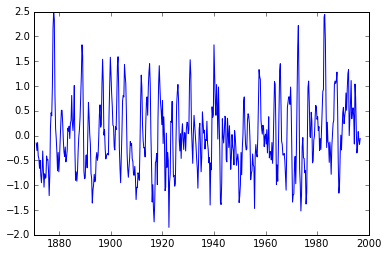

In [27]:
f, ax = plt.subplots()
ax.plot(time,data)
xlim = [1870,2000]  # plotting range
ax.set_xlim(xlim)

In [28]:
variance = np.std(data)**2
mean=np.mean(data)
data = (data - np.mean(data))/np.sqrt(variance)
print "mean=",mean
print "std=", np.sqrt(variance)

mean= -1.98412698413e-05
std= 0.733599112824


#### set wavelet parameters

In [29]:
pad = 1      # pad the time series with zeroes (recommended)
dj = 0.25    # this will do 4 sub-octaves per octave
s0 = 2.*dt    # this says start at a scale of 6 months
j1 = 7./dj    # this says do 7 powers-of-two with dj sub-octaves each
lag1 = 0.72  # lag-1 autocorrelation for red noise background
mother = 'Morlet'

#### wavelet transform

In [30]:
wave,period,scale,coi = wavelet(data,dt,pad,dj,s0,j1,mother);
power = (np.abs(wave))**2         # compute wavelet power spectrum

#### significance levels

In [31]:
signif,fft_theor = wave_signif(1.0,dt,scale,0,lag1,-1,-1,mother)
sig95 = np.dot(signif.reshape(len(signif),1),np.ones((1,N))) # expand signif --> (J+1)x(N) array
sig95 = power / sig95         # where ratio > 1, power is significant

In [32]:
global_ws = variance*power.sum(axis=1)/float(N)   # time-average over all times
dof = N - scale  # the -scale corrects for padding at edges
global_signif,fft_theor = wave_signif(variance,dt,scale,1,lag1,-1,dof,mother)

#### scale-average between 2 and 8 years

In [33]:
avg = (scale >= 2) & (scale < 8)
Cdelta = 0.776;   # this is for the MORLET wavelet
scale_avg = np.dot(scale.reshape(len(scale),1),np.ones((1,N))) # expand scale --> (J+1)x(N) array
scale_avg = power / scale_avg   # [Eqn(24)]
scale_avg = variance*dj*dt/Cdelta*sum(scale_avg[avg,:])   # [Eqn(24)]
scaleavg_signif ,fft_theor= wave_signif(variance,dt,scale,2,lag1,-1,[2,7.9],mother)

In [34]:
iwave=wavelet_inverse(wave, scale, dt, dj, "Morlet")
print "root square mean error",np.sqrt(np.sum((data-iwave)**2)/float(len(data)))*np.sqrt(variance),"deg C"

root square mean error 0.0775581101677 deg C


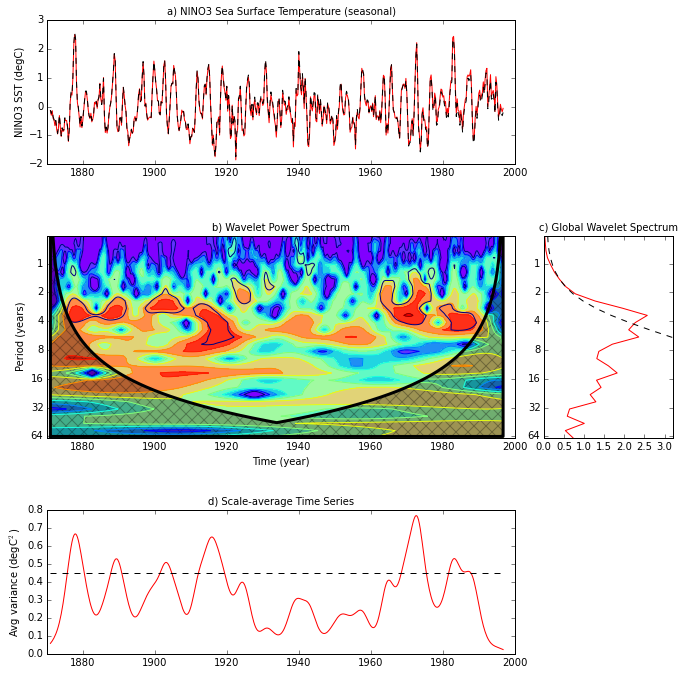

In [36]:
#figure size
fig=plt.figure(figsize=(10,10))

# subplot positions
width= 0.65
hight = 0.28;
pos1a = [0.1, 0.75, width, 0.2]
pos1b = [0.1, 0.37, width, hight]
pos1c = [0.79, 0.37, 0.18, hight]
pos1d = [0.1,  0.07, width, 0.2]

#########################################
#---- a) Original signal
#########################################
ax=fig.add_axes(pos1a)
#original
ax.plot(time,data*np.sqrt(variance)+mean,"r-")
#reconstruction
ax.plot(time,iwave*np.sqrt(variance)+mean,"k--")

ax.set_ylabel('NINO3 SST (degC)')
plt.title('a) NINO3 Sea Surface Temperature (seasonal)')

#########################################
#   b) Wavelet spectrum
#########################################

#--- Contour plot wavelet power spectrum
bx=fig.add_axes(pos1b,sharex=ax)
levels = [0.0625,0.125,0.25,0.5,1,2,4,8,16] 
Yticks = 2**(np.arange(np.int(np.log2(np.min(period))),np.int(np.log2(np.max(period)))+1))
bx.contour(time,np.log2(period),np.log2(power),np.log2(levels))
bx.contourf(time,np.log2(period),np.log2(power),np.log2(levels), extend='both', cmap=plt.get_cmap('rainbow'))
bx.set_xlabel('Time (year)')
bx.set_ylabel('Period (years)')
import matplotlib.ticker as ticker
ymajorLocator=ticker.FixedLocator(np.log2(Yticks))
bx.yaxis.set_major_locator( ymajorLocator )
ticks=bx.yaxis.set_ticklabels(Yticks)
plt.title('b) Wavelet Power Spectrum')

# 95% significance contour, levels at -99 (fake) and 1 (95% signif)
cs = bx.contour(time,np.log2(period),sig95,[1],color='k',linewidth=1)

# cone-of-influence, anything "below" is dubious
ts = time;
coi_area = np.concatenate([[np.max(scale)], coi, [np.max(scale)],[np.max(scale)]])
ts_area = np.concatenate([[ts[0]], ts, [ts[-1]] ,[ts[0]]]);
L = bx.plot(ts_area,np.log2(coi_area),'k',linewidth=3)
F=bx.fill(ts_area,np.log2(coi_area),'k',alpha=0.3,hatch="xx")

#########################################
#   c) Global Wavelet spectrum
#########################################

#--- Plot global wavelet spectrum
cx=fig.add_axes(pos1c,sharey=bx)
cx.plot(global_ws,np.log2(period),"r-")
cx.plot(global_signif,np.log2(period),'k--')
ylim=cx.set_ylim(np.log2([period.min(),period.max()]))
cx.invert_yaxis()
plt.title('c) Global Wavelet Spectrum')
xrangec=cx.set_xlim([0,1.25*np.max(global_ws)])

#########################################
#   d) Scale average Spectrum
#########################################
#--- Plot Scale-averaged spectrum -----------------
dx=fig.add_axes(pos1d,sharex=bx)
dx.plot(time,scale_avg,"r-")
dx.plot([time[0],time[-1]],[scaleavg_signif,scaleavg_signif],"k--")
xrange=dx.set_xlim(xlim)
dx.set_ylabel('Avg variance (degC$^2$)')
title=plt.title('d) Scale-average Time Series')
plt.savefig("nino3_TorrenceCompo.png")

#### Bias rectification

divides by scales

In [52]:
########################
#  Spectrum
########################
powers=np.zeros_like(power)
for k in range(len(scale)):
    powers[k,:] = power[k,:]/scale[k]
#significance: sig95 is already normalized = 1

########################
#  Spectrum
########################
global_wss = global_ws/scale   
global_signifs=global_signif/scale

########################
#  Scale-average between El Nino periods of 2--8 years
########################
# No need to change 
# because in Eqn(24) of Torrence and Compo [1998], division by scale has been done.
scale_avgs=scale_avg
scaleavg_signifs=scaleavg_signif

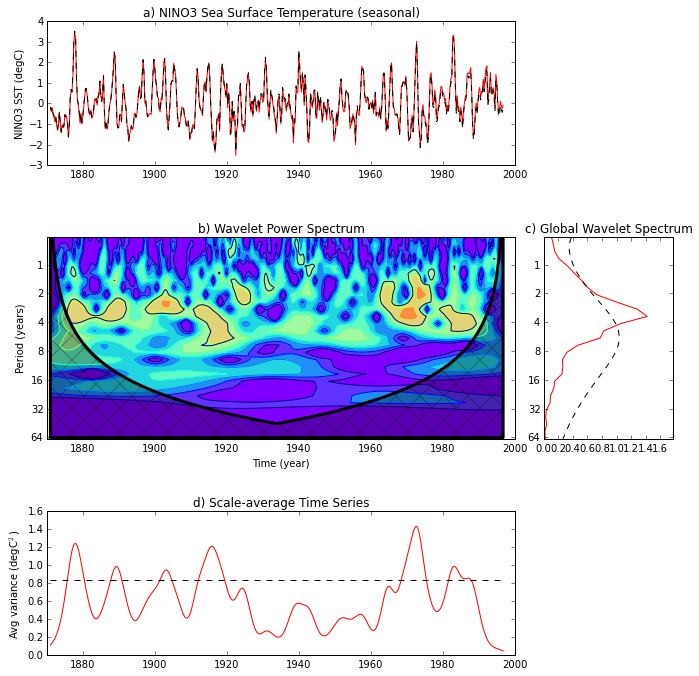

In [53]:
#figure size
fig=plt.figure(figsize=(10,10))

# subplot positions
width= 0.65
hight = 0.28;
pos1a = [0.1, 0.75, width, 0.2]
pos1b = [0.1, 0.37, width, hight]
pos1c = [0.79, 0.37, 0.18, hight]
pos1d = [0.1,  0.07, width, 0.2]

#########################################
#---- a) Original signal
#########################################
ax=fig.add_axes(pos1a)
#original
ax.plot(time,data*np.sqrt(variance)+mean,"r-")
#reconstruction
ax.plot(time,iwave*np.sqrt(variance)+mean,"k--")

ax.set_ylabel('NINO3 SST (degC)')
plt.title('a) NINO3 Sea Surface Temperature (seasonal)')

#########################################
#   b) Wavelet spectrum
#########################################

#--- Contour plot wavelet power spectrum
bx=fig.add_axes(pos1b,sharex=ax)
levels = [0.0625,0.125,0.25,0.5,1,2,4,8,16] 
Yticks = 2**(np.arange(np.int(np.log2(np.min(period))),np.int(np.log2(np.max(period)))+1))
bx.contour(time,np.log2(period),np.log2(powers),np.log2(levels))
bx.contourf(time,np.log2(period),np.log2(powers),np.log2(levels), extend='both', cmap=plt.get_cmap('rainbow'))
bx.set_xlabel('Time (year)')
bx.set_ylabel('Period (years)')
import matplotlib.ticker as ticker
ymajorLocator=ticker.FixedLocator(np.log2(Yticks))
bx.yaxis.set_major_locator( ymajorLocator )
ticks=bx.yaxis.set_ticklabels(Yticks)
plt.title('b) Wavelet Power Spectrum')

# 95% significance contour, levels at -99 (fake) and 1 (95% signif)
cs = bx.contour(time,np.log2(period),sig95,[1],color='k',linewidth=1)

# cone-of-influence, anything "below" is dubious
ts = time;
coi_area = np.concatenate([[np.max(scale)], coi, [np.max(scale)],[np.max(scale)]])
ts_area = np.concatenate([[ts[0]], ts, [ts[-1]] ,[ts[0]]]);
L = bx.plot(ts_area,np.log2(coi_area),'k',linewidth=3)
F=bx.fill(ts_area,np.log2(coi_area),'k',alpha=0.3,hatch="x")

#########################################
#   c) Global Wavelet spectrum
#########################################

#--- Plot global wavelet spectrum
cx=fig.add_axes(pos1c,sharey=bx)
cx.plot(global_wss,np.log2(period),"r-")
cx.plot(global_signifs,np.log2(period),'k--')
ylim=cx.set_ylim(np.log2([period.min(),period.max()]))
cx.invert_yaxis()
plt.title('c) Global Wavelet Spectrum')
xrangec=cx.set_xlim([0,1.25*np.max(global_wss)])

#########################################
#   d) Global Wavelet spectrum
#########################################
#--- Plot Scale-averaged spectrum -----------------
dx=fig.add_axes(pos1d,sharex=bx)
dx.plot(time,scale_avgs,"r-")
dx.plot([time[0],time[-1]],[scaleavg_signifs,scaleavg_signifs],"k--")
xrange=dx.set_xlim(xlim)
dx.set_ylabel('Avg variance (degC$^2$)')
title=plt.title('d) Scale-average Time Series')